In [1]:
import numpy as np
import random
import time
tol = 10^-4

In [2]:
def kernel_expo(x,y,c):
    return np.exp(-np.linalg.norm(x-y)**2/c)

In [3]:
def KKTviol(O,rho,mu,l,alpha,ens):
    ens = list(ens)
    random.shuffle(ens)
    for index in ens:
        if (O[index] -rho)*alpha[index]>0 or (rho-O[index])*(1/(mu*l)-alpha[index])>0:
            #print((O[index] -rho)*alpha[index],(rho-O[index])*(1/(mu*l)-alpha[index]),alpha[index])
            return index
    return -1

In [4]:
def argmax(O,i,ens):
    index = 0
    value = 0
    ens = list(ens)
    for j in ens:
        if value < abs(O[i]-O[j]):
            value = abs(O[i]-O[j])
            index = j
    #print(len(ens))
    #time.sleep(0.5)
    return index

In [5]:
def optim(alpha,i,j,K,O,mu,l):
    delta = alpha[i]+alpha[j]
    Ci = O[i] - alpha[i]*K[i,i] -alpha[j]*K[i,j]
    Cj = O[j] - alpha[i]*K[i,j] -alpha[j]*K[j,j]
    # Condition droite (inutile dans le cas du noyau gaussien)
    if K[i,i]+K[j,j]-2*K[i,j] == 0:
        if Cj-Ci-K[i,i]>0:
            alphaj = max(0,delta-1/(l*mu))
            alphai = delta - alphaj
        elif Cj-Ci-K[i,i] <0:
            alphaj = min(1/(l*mu),delta)
            alphai = delta - alphaj
        else :
            alphaj = alpha[j]
            alphai = alpha[i]
    else:
        xmin =  (delta*(K[i,i]-K[i,j])+Ci-Cj)/( K[i,i]+K[j,j]-2*K[i,j])
        
        # condition si le min n'est pas atteint dans 0 1/(l*mu)
        # condition sur K inutile si noyau gaussien
        if K[i,i]+K[j,j]-2*K[i,j] < 0 or xmin <max(0,delta-1/(mu*l)) or xmin > min(1/(mu*l),delta):
            #print("sur les bords",K[i,i]+K[j,j]-2*K[i,j],xmin)
            #time.sleep(1)
            x0 = max(0,delta-1/(l*mu))
            fx0  = 1/2*(delta-x0)**2*K[i,i] + (delta-x0)*K[i,j] + 1/2*x0**2*K[j,j] + (delta-x0)*Ci + x0*Cj
            xmu = min(1/(l*mu),delta)
            fxmu  = 1/2*(delta-xmu)**2*K[i,i] + (delta-xmu)*K[i,j] + 1/2*xmu**2*K[j,j] + (delta-xmu)*Ci + xmu*Cj
            if fx0 > fxmu:
                alphaj = xmu
                alphai = delta - alphaj
            else :
                alphaj = x0
                alphai = delta - alphaj
        else :
            #print("A l'intérieur",xmin)
            #time.sleep(1)
            alphaj = xmin
            alphai = delta - alphaj
        """
        alphaj = alpha[j] + (O[i]-O[j])/(K[i,i]+K[j,j]-2*K[i,j])
        if alphaj < 0:
            alphaj = 0
        if alphaj >1/(l*mu):
            #print("l",l,mu)
            alphaj = 1/(l*mu)
        delta = alpha[i]+alpha[j]
        alphai = delta - alphaj
        """
    #print(alphai,alphaj)
    #print("alphai , alphaj : ",alphai,alphaj,alpha[i],alpha[j] , " delta : ", delta)
    #if alpha[i]+alpha[j] != alphai + alphaj:
    #    print("delta : ",alpha[i]+alpha[j], alphai + alphaj)
    return alphai,alphaj
    

In [6]:
def SVcalc(alpha,c):
    return list(np.where((alpha>0)&(alpha<c))[0])

In [7]:
class osvm:
    def __init__(self,mu=0.01,maxiter=10000,eps=0.001):
        assert mu>0,"mu doit être strictement positif"
        assert mu<=1,"mu doit être inférieur à 1"
        self.mu = mu
        self.eps = eps
        self.maxiter = maxiter
        
    def fit(self,data):
        self.alpha = np.zeros(np.size(data))
        self.l = np.size(data)    
        l = self.l
        self.data = data
        K = np.array([[kernel_expo(x,y,0.5) for x in data] for y in data])
        choose = [i for i in range(l)]
        self.rho = 0
        s = 0
        while s <= 1-1/(1.25*l*self.mu):
            index = np.random.randint(len(choose))
            elem = choose[index]
            choose.remove(elem)
            self.alpha[elem] = 1/(1.25*l*self.mu)
            s += 1/(1.25*l*self.mu)
        if s != 1:
            index = np.random.randint(len(choose))
            elem = choose[index]
            choose.remove(elem)
            self.alpha[elem] = 1-s
            #print(1-s)
            s = 1
        #C = np.dot(self.alpha[2:],K[2:,:])
        O = np.dot(self.alpha,K)
        self.rho = max(O[self.alpha>0])
        #print(sum(self.alpha))
        
        iteration = 0
        while iteration < self.maxiter:
            # Etape (i)
            index = KKTviol(O,self.rho,self.mu,l,self.alpha,range(l))
            if index == -1:
                break
            iteration += 1
            SV = SVcalc(self.alpha,1/(self.mu*l))
            
            """if SV == []:
                SV_rand = np.random.randint(len(self.alpha))
                while SV_rand == index:
                    SV_rand = np.random.randint(len(self.alpha))
                SV = [SV_rand]"""
            if SV == []:
                print("SV empty")
                continue
            j = argmax(O,index,SV)
            #print("before",self.alpha[index],self.alpha[j])
            self.alpha[index],self.alpha[j] = optim(self.alpha,index,j,K,O,self.mu,l)
            if sum(self.alpha) > 1.001:
                print("etape i " ,sum(self.alpha))
                time.sleep(0.5)
            #print("after",self.alpha[index],self.alpha[j])
            
            # update de rho
            O = np.dot(self.alpha,K)
            self.rho = min(O[(self.alpha>0) & (self.alpha< 1/(self.mu*l))])
            
            SV = SVcalc(self.alpha,1/(self.mu*l))
            
            # Etape (ii)
            index = KKTviol(O,self.rho,self.mu,l,self.alpha,SV)
            maxiterii = 1000
            iterii = 0
            while index !=-1 and iterii < maxiterii and len(SV)>1:
                iterii += 1
                j = argmax(O,index,SV)
                #print("j " , j)
                #time.sleep(0.5)
                #print("before",self.alpha[index],self.alpha[j])
                delta = self.alpha[index] + self.alpha[j]
                #self.alpha[index],self.alpha[j] 
                alphai , alphaj = optim(self.alpha,index,j,K,O,self.mu,l)
                self.alpha[index] = alphai
                self.alpha[j] = alphaj
                if sum(self.alpha) > 1.001:
                    print("etape ii " ,sum(self.alpha))
                    print(self.alpha[index] + self.alpha[j] , delta, alphai + alphaj)
                    print(index,j)
                    time.sleep(0.5)
                #print("after",self.alpha[index],self.alpha[j])
                #time.sleep(0.5)
                # update de rho
                #print(np.size(self.alpha),np.size(K))
                O = np.dot(self.alpha,K)
                self.rho = min(O[ (self.alpha>0)& (self.alpha < 1/(self.mu*l)) ])
                
                #print(index)
                SV = SVcalc(self.alpha,1/(self.mu*l))
                #print(" longueur sv " ,len(SV))
                index = KKTviol(O,self.rho,self.mu,l,self.alpha,SV)
                
            if iterii == maxiterii :
                
                print("Boucle (ii) infinie")
                """
                rargmax = 0
                rmax = 0
                for i in range(len(self.alpha)):
                    alp = self.alpha[i]
                    if alp >0 and alp < 1*(self.mu*l):
                        print(O[i])
                        if O[i]> rmax:
                            rmax = O[i]
                            rargmax = i
                            """
                #print(min(O[ (self.alpha>0)& (self.alpha < 1/(self.mu*l)) ]),max(O[ (self.alpha>0)& (self.alpha < 1/(self.mu*l)) ]))
                #print("sum : " , sum(self.alpha))
                print(self.rho)
                #print(self.rho,rargmax,O[rargmax],self.alpha[rargmax],rmax)

            if iteration%1000 == 0 :
                print(iteration,self.maxiter)
                
        #return self.alpha,self.rho    
    
    def eval(self,xi):
        K = np.array([kernel_expo(x,xi,0.5) for x in self.data])
        return (np.dot(self.alpha,K)-self.rho)

In [ ]:
test = osvm(0.01)
data = 2*(-0.5 + np.random.rand(1000))
test.fit(data)

In [110]:
# probleme de la projection de alpha1 et alpha2
#return alpha?
test.rho

0.99634626274232829

In [111]:
import matplotlib.pyplot as plt
%matplotlib inline

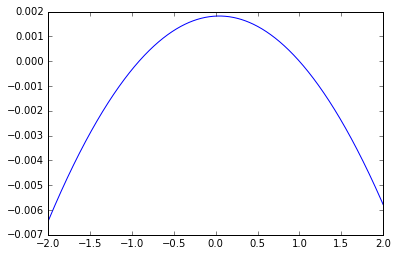

In [112]:
x=np.linspace(-2,2,1000)
y = list(map(lambda x :test.eval(x),x))
plt.plot(x,y)

In [107]:
test.eval(-0.5)

-8.7329497072907714e-05

In [113]:
test.alpha

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0